<a href="https://colab.research.google.com/github/LarsPetschke/Capstone_Project_Car_Dataset/blob/main/Capstone_Project_Car_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GOOGLE Data Analytics**
# **Capstone Project:** Car Dataset
***
## by Lars Petschke


## 1. Ask
***
**Business Task** \
“What factors influence the price and popularity of cars, and how are engine performance and fuel efficiency related to these factors?”
\
\
**Project Objective**\
“The aim of this analysis is to uncover patterns in pricing (MSRP), fuel efficiency and engine performance of different vehicle types to support marketing and product positioning strategies.”

## 2. Prepare
***
**Data Summary**\
The dataset contains car ads with attributes such as make, model, year, engine type, fuel economy (MPG), popularity and MSRP. Only vehicles from 1995 and later were included. Columns with missing values were filled in using internet research (e.g. 'market category', 'engine type', 'number of doors'). Duplicates were removed.


### 2.1.   Import Python libraries and load the data set
***
First, all necessary libraries were imported, including also the data set.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive/')

# load csv
df_car = pd.read_csv('/content/drive/MyDrive/Google_Capstone_Project/car_dataset.csv')

# copy raw_data
df_car_raw = df_car.copy()

#display the first five rows
df_car.head()

# save path for plots
save_path = '/content/drive/MyDrive/Google_Capstone_Project/plots'

# prove if path exist, else create
import os
if not os.path.exists(save_path):
    os.makedirs(save_path)


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### 2.2 Activate R Magic and Install & Import R Packages
***
In addition to the Python libraries, I also activated R-Magie and installed and imported the necessary packages.

In [2]:
# activate R Magic
%load_ext rpy2.ipython

In [3]:
%%R
# Install R packages (corrected names and quoted strings)
if (!require("ggplot2")) install.packages("ggplot2", dependencies = TRUE)
if (!require("dplyr")) install.packages("dplyr", dependencies = TRUE)
if (!require("gridExtra")) install.packages("gridExtra", dependencies = TRUE)
if (!require("tidyr")) install.packages("tidyr", dependencies = TRUE)
if (!require("reshape2")) install.packages("reshape2", dependencies = TRUE)
if (!require("viridis")) install.packages("viridis", dependencies = TRUE)
if (!require("RColorBrewer")) install.packages("RColorBrewer", dependencies = TRUE)


Loading required package: ggplot2
Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: gridExtra

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine

Loading required package: tidyr
Loading required package: reshape2

Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths

Loading required package: viridis
Loading required package: viridisLite
Loading required package: RColorBrewer


In [4]:
%%R
# import libraries
library(ggplot2)
library(dplyr)
library(gridExtra)
library(tidyr)
library(reshape2)
library(viridis)
library(RColorBrewer)

In [5]:
# Use path for saving plots in R
%R -i save_path


## 3. Process
***
**Data Cleaning & Feature Engineering:**

All data cleansing steps were carried out in this chapter. Nan values were examined and revised, data types were inspected and converted, the dataset was filtered for all vehicles after 1995 and all text columns were converted to lower case for consistency. New features were then created: 'total MPG' as the average of city and highway MPG and 'price per horsepower' calculated as MSRP divided by engine horsepower. The data types were adjusted and outliers were checked.



### 3.1 Handle Missing Data
***
Missing values were searched for step by step. As every car model is very well documented and reported on the Internet, I researched the missing values there.

In [6]:
# check for columns, NaN values, dtypes and memory usage
df_car.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  
dtypes: float64(3), int64(5

In [7]:
# let's drop duplicates out of the dataset (if there are any existing)
df_car = df_car.drop_duplicates()

In [8]:
# show only columns with NaN values

missing_values = df_car.isna().sum()
mv = missing_values[missing_values >0]
print(mv)

Engine Fuel Type       3
Engine HP             69
Engine Cylinders      30
Number of Doors        6
Market Category     3376
dtype: int64


summary missing values

''Engine HP', 'Engine Cylinders', 'Number of Doors'

    --> cars are well documented in the www
      - fill NaN values with car specific values by using google search


Other Opportunities are:

- Market category
      -  complex way (separate values in separate columns)
      -  substitute NaN values with 'None' (seems to be only cars)


- 'Engine HP' & 'Engine Cylinders'
      - validate, if cars are electric, there are zero cylinders
      - compare 'Make', 'Model', 'engine' to determine values for 'Engine HP' & 'Engine Cylinders' (complex)
      - google search and insert data

Number of Doors

    - Tesla --> 4 Doors
    - Ferrari --> 2 Doors



In [9]:
#fill for NaN in TESLA Model S --> 4 Doors
df_car.loc[(df_car['Make'] == 'Tesla') & (df_car['Model'] == 'Model S'),'Number of Doors'] = df_car.loc[(df_car['Make'] == 'Tesla') & (df_car['Model'] == 'Model S'),'Number of Doors'].fillna(4)

#fill for NaN in Ferrari --> 2 Doors
df_car.loc[(df_car['Make'] == 'Ferrari') & (df_car['Model'] == 'FF'),'Number of Doors'] = df_car.loc[(df_car['Make'] == 'Ferrari') & (df_car['Model'] == 'FF'),'Number of Doors'].fillna(2)

# df_car.loc[df_car['Number of Doors'].isna()]

Market Category

    - don't drop/remove column or similar actions
    - set NaN values to None (no special category is available)

In [10]:
df_car = df_car.copy()
df_car['Market Category'] = df_car['Market Category'].fillna('None')
df_car[df_car['Market Category'].isna()]

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP


Engine HP

    - values for for all these missing values are well documented in www

In [11]:
#fill NaN in Mitsubishi	i-MiEV --> 66 HP
df_car.loc[(df_car['Make'] == 'Mitsubishi') & (df_car['Model'] == 'i-MiEV'),'Engine HP'] = df_car.loc[(df_car['Make'] == 'Mitsubishi') & (df_car['Model'] == 'i-MiEV'),'Engine HP'].fillna(66)

#fill NaN in 500e --> 94 HP
df_car.loc[(df_car['Make'] == 'FIAT') & (df_car['Model'] == '500e'),'Engine HP'] = df_car.loc[(df_car['Make'] == 'FIAT') & (df_car['Model'] == '500e'),'Engine HP'].fillna(94)

#fill NaN in KIA Soel --> 109 HP
df_car.loc[(df_car['Make'] == 'Kia') & (df_car['Model'] == 'Soul EV'),'Engine HP'] = df_car.loc[(df_car['Make'] == 'Kia') & (df_car['Model'] == 'Soul EV'),'Engine HP'].fillna(109)

#fill NaN in Honda Fit EV --> 123 HP
df_car.loc[(df_car['Make'] == 'Honda') & (df_car['Model'] == 'Fit EV'),'Engine HP'] = df_car.loc[(df_car['Make'] == 'Honda') & (df_car['Model'] == 'Fit EV'),'Engine HP'].fillna(123)

#fill NaN in Mercedes-Benz M-Class--> 200 HP
df_car.loc[(df_car['Make'] == 'Mercedes-Benz') & (df_car['Model'] == 'M-Class'),'Engine HP'] = df_car.loc[(df_car['Make'] == 'Mercedes-Benz') & (df_car['Model'] == 'M-Class'),'Engine HP'].fillna(200)

#fill NaN in Toyota RAV4 EV --> 154 HP
df_car.loc[(df_car['Make'] == 'Toyota') & (df_car['Model'] == 'RAV4 EV'),'Engine HP'] = df_car.loc[(df_car['Make'] == 'Toyota') & (df_car['Model'] == 'RAV4 EV'),'Engine HP'].fillna(154)

#fill NaN in FORD Freestar --> 201 HP
df_car.loc[(df_car['Make'] == 'Ford') & (df_car['Model'] == 'Freestar'),'Engine HP'] = df_car.loc[(df_car['Make'] == 'Ford') & (df_car['Model'] == 'Freestar'),'Engine HP'].fillna(201)

#fill NaN in FORD Escape --> 245 HP
df_car.loc[(df_car['Make'] == 'Ford') & (df_car['Model'] == 'Escape'),'Engine HP'] = df_car.loc[(df_car['Make'] == 'Ford') & (df_car['Model'] == 'Escape'),'Engine HP'].fillna(245)

#fill NaN in FORD Focus --> 143 HP
df_car.loc[(df_car['Make'] == 'Ford') & (df_car['Model'] == 'Focus'),'Engine HP'] = df_car.loc[(df_car['Make'] == 'Ford') & (df_car['Model'] == 'Focus'),'Engine HP'].fillna(143)

#fill NaN in Lincoln Continental --> 305 HP
df_car.loc[(df_car['Make'] == 'Lincoln') & (df_car['Model'] == 'Continental'),'Engine HP'] = df_car.loc[(df_car['Make'] == 'Lincoln') & (df_car['Model'] == 'Continental'),'Engine HP'].fillna(305)

#fill NaN in Lincoln MKZ --> 245 HP
df_car.loc[(df_car['Make'] == 'Lincoln') & (df_car['Model'] == 'MKZ'),'Engine HP'] = df_car.loc[(df_car['Make'] == 'Lincoln') & (df_car['Model'] == 'MKZ'),'Engine HP'].fillna(145)

#fill NaN in Chevrolet Impala --> 305 HP
df_car.loc[(df_car['Make'] == 'Chevrolet') & (df_car['Model'] == 'Impala'),'Engine HP'] = df_car.loc[(df_car['Make'] == 'Chevrolet') & (df_car['Model'] == 'Impala'),'Engine HP'].fillna(305)

#fill NaN in NISSAN Leaf electric --> 147 HP
df_car.loc[(df_car['Make'] == 'Nissan') & (df_car['Model'] == 'Leaf') & (df_car['Engine Fuel Type'] == 'electric'),'Engine HP'] = df_car.loc[(df_car['Make'] == 'Nissan') & (df_car['Model'] == 'Leaf') & (df_car['Engine Fuel Type'] == 'electric'),'Engine HP'].fillna(147)

#fill NaN in TESLA Model S AWD High Performance --> 691 HP
df_car.loc[(df_car['Driven_Wheels'] == 'all wheel drive') & (df_car['Model'] == 'Model S') & (df_car['Market Category'] == 'Exotic,High-Performance'),'Engine HP'] = df_car.loc[(df_car['Driven_Wheels'] == 'all wheel drive') & (df_car['Model'] == 'Model S') & (df_car['Market Category'] == 'Exotic,High-Performance'),'Engine HP'].fillna(691)

#fill NaN in TESLA Model S AWD Exotic,Performance --> AWD 762 / RWD 417 HP
df_car.loc[(df_car['Driven_Wheels'] == 'all wheel drive') & (df_car['Model'] == 'Model S') & (df_car['Market Category'] == 'Exotic,Performance'),'Engine HP'] = df_car.loc[(df_car['Driven_Wheels'] == 'all wheel drive') & (df_car['Model'] == 'Model S') & (df_car['Market Category'] == 'Exotic,Performance'),'Engine HP'].fillna(762)

#fill NaN in TESLA Model S AWD Exotic,Performance --> AWD 762 / RWD 362 HP
df_car.loc[(df_car['Driven_Wheels'] == 'rear wheel drive') & (df_car['Model'] == 'Model S') & (df_car['Market Category'] == 'Exotic,Performance'),'Engine HP'] = df_car.loc[(df_car['Driven_Wheels'] == 'rear wheel drive') & (df_car['Model'] == 'Model S') & (df_car['Market Category'] == 'Exotic,Performance'),'Engine HP'].fillna(362)

#fill NaN in TESLA Model S AWD Exotic,Exotic,High-Performance --> AWD 762 / RWD 416 HP
df_car.loc[(df_car['Driven_Wheels'] == 'rear wheel drive') & (df_car['Model'] == 'Model S') & (df_car['Market Category'] == 'Exotic,High-Performance'),'Engine HP'] = df_car.loc[(df_car['Driven_Wheels'] == 'rear wheel drive') & (df_car['Model'] == 'Model S') & (df_car['Market Category'] == 'Exotic,High-Performance'),'Engine HP'].fillna(416)


Driven Wheels

      - Four Categries in this list available
          - front wheel drive
          - rear wheel drive
          - four wheel drive
          - all wheel drive

      --> all wheel drive = four wheel drive (unify this values)

In [12]:
# unify 'four wheel drive' & 'all wheel drive' to 'all wheel drive'
df_car = df_car.copy()
df_car['Driven_Wheels'] = df_car['Driven_Wheels'].replace('four wheel drive', 'all wheel drive')

Engine Cylinder

    - EV --> 0.0 cyl.
    - Mazda RX-8 --> 2 cyl.

Engine Fuel Type

    - Suzuki Verona --> premium unleaded (recommended)

In [13]:
# searches for EVs and set Engine Cylinders to 0.0
df_car.loc[df_car['Engine Fuel Type'] == 'electric', 'Engine Cylinders'] = df_car.loc[df_car['Engine Fuel Type'] == 'electric', 'Engine Cylinders'].fillna(0.0)

#searches for NaN in Engine Cylinders --> Mazda RX-8
df_car.loc[(df_car['Make']== 'Mazda'), 'Engine Cylinders'] = df_car.loc[(df_car['Make']== 'Mazda'), 'Engine Cylinders'].fillna(2)

#searches for NaN in Engine Fuel Type --> Suzuki Verona from 2004
df_car.loc[df_car['Engine Fuel Type'].isna()]
df_car.loc[(df_car['Make']== 'Suzuki'), 'Engine Fuel Type'] = df_car.loc[(df_car['Make']== 'Suzuki'), 'Engine Fuel Type'].fillna('premium unleaded (recommended)')

df_car.isna().sum()

,0
Make,0
Model,0
Year,0
Engine Fuel Type,0
Engine HP,0
Engine Cylinders,0
Transmission Type,0
Driven_Wheels,0
Number of Doors,0
Market Category,0


In [14]:
# let's drop duplicates out of the dataset (if there are any existing)
df_car = df_car.drop_duplicates()
df_car.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11195 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11195 non-null  object 
 1   Model              11195 non-null  object 
 2   Year               11195 non-null  int64  
 3   Engine Fuel Type   11195 non-null  object 
 4   Engine HP          11195 non-null  float64
 5   Engine Cylinders   11195 non-null  float64
 6   Transmission Type  11195 non-null  object 
 7   Driven_Wheels      11195 non-null  object 
 8   Number of Doors    11195 non-null  float64
 9   Market Category    11195 non-null  object 
 10  Vehicle Size       11195 non-null  object 
 11  Vehicle Style      11195 non-null  object 
 12  highway MPG        11195 non-null  int64  
 13  city mpg           11195 non-null  int64  
 14  Popularity         11195 non-null  int64  
 15  MSRP               11195 non-null  int64  
dtypes: float64(3), int64(5), ob

In [15]:
# statistics of dataset
df_describe = df_car.describe(include='int').round(2)
df_describe

,Year,highway MPG,city mpg,Popularity,MSRP
count,11195.00,11195.00,11195.00,11195.00,11195.00
mean,2010.72,26.61,19.73,1557.02,41929.36
std,7.23,8.98,9.18,1443.85,61545.76
min,1990.00,12.00,7.00,2.00,2000.00
25%,2007.00,22.00,16.00,549.00,21599.00
50%,2015.00,25.00,18.00,1385.00,30675.00
75%,2016.00,30.00,22.00,2009.00,43037.50
max,2017.00,354.00,137.00,5657.00,2065902.00


In [16]:
# statistics of dataset
df_describe_all = df_car.describe(include='object')
df_describe_all


,Make,Model,Engine Fuel Type,Transmission Type,Driven_Wheels,Market Category,Vehicle Size,Vehicle Style
count,11195,11195,11195,11195,11195,11195,11195,11195
unique,48,915,10,5,3,72,3,16
top,Chevrolet,Silverado 1500,regular unleaded,AUTOMATIC,front wheel drive,None,Compact,Sedan
freq,1083,156,6654,7928,4354,3374,4391,2843


###  3.2   Data Type Conversion
***
I have made sure that the columns have the correct data type for the analysis.





In [17]:
df_car = df_car.copy()
df_car['city mpg'] = df_car['city mpg'].astype(float)
df_car['highway MPG'] = df_car['highway MPG'].astype(float)
df_car['Engine HP'] = df_car['Engine HP'].astype(int)
df_car['Engine Cylinders'] = df_car['Engine Cylinders'].astype(int)
df_car['Number of Doors'] = df_car['Number of Doors'].astype(int)
df_car.dtypes

,0
Make,object
Model,object
Year,int64
Engine Fuel Type,object
Engine HP,int64
Engine Cylinders,int64
Transmission Type,object
Driven_Wheels,object
Number of Doors,int64
Market Category,object


### 3.3   Filter Data
***
In this part of the processing, I have filtered the data set so that it only contains vehicles from 1995 and later.




In [18]:
df_car = df_car[df_car['Year']>=1995]

  ### 3.4 String Operations
***
I have standardized the text entries in the following columns to lower size:
- Vehicle Style
- Market Category

In [19]:
df_car = df_car.copy()
df_car['Vehicle Style'] = df_car['Vehicle Style'].str.lower()
df_car['Market Category'] = df_car['Market Category'].str.lower()
df_car.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335,6,MANUAL,rear wheel drive,2,"factory tuner,luxury,high-performance",Compact,coupe,26.0,19.0,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300,6,MANUAL,rear wheel drive,2,"luxury,performance",Compact,convertible,28.0,19.0,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300,6,MANUAL,rear wheel drive,2,"luxury,high-performance",Compact,coupe,28.0,20.0,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230,6,MANUAL,rear wheel drive,2,"luxury,performance",Compact,coupe,28.0,18.0,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230,6,MANUAL,rear wheel drive,2,luxury,Compact,convertible,28.0,18.0,3916,34500


###   3.5  Feature Engineering
***
- 'Total MPG' as average of 'city mpg' & 'highway MPG'
- 'Price per HP' as 'MSRP' / 'Engine HP'



In [20]:
df_car = df_car.copy()
df_car['Total MPG'] = df_car[['city mpg', 'highway MPG']].mean(axis=1)
df_car['Price per HP'] = (df_car['MSRP'] / df_car['Engine HP']).round()
df_car.head()


,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP,Total MPG,Price per HP
0,BMW,1 Series M,2011,premium unleaded (required),335,6,MANUAL,rear wheel drive,2,"factory tuner,luxury,high-performance",Compact,coupe,26.0,19.0,3916,46135,22.5,138.0
1,BMW,1 Series,2011,premium unleaded (required),300,6,MANUAL,rear wheel drive,2,"luxury,performance",Compact,convertible,28.0,19.0,3916,40650,23.5,136.0
2,BMW,1 Series,2011,premium unleaded (required),300,6,MANUAL,rear wheel drive,2,"luxury,high-performance",Compact,coupe,28.0,20.0,3916,36350,24.0,121.0
3,BMW,1 Series,2011,premium unleaded (required),230,6,MANUAL,rear wheel drive,2,"luxury,performance",Compact,coupe,28.0,18.0,3916,29450,23.0,128.0
4,BMW,1 Series,2011,premium unleaded (required),230,6,MANUAL,rear wheel drive,2,luxury,Compact,convertible,28.0,18.0,3916,34500,23.0,150.0


## 4. Analyze
***
**Exploratory Data Analysis (EDA):**

Descriptive statistics were calculated for engine power, MSRP, popularity, MPG in the city and MPG on the highway. Grouped analyses showed average MSRP and popularity by driven_wheels, vehicle size, and engine cylinder.
***
**Visualizations included:**

- Histogram of city MPG

- Bar chart of average MSRP by Vehicle Size

- Scatter plot of Engine HP vs. MSRP

- Box plot of MSRP by Driven_Wheels

- Line plot showing city and highway MPG by Transmission Type

- Correlation heatmap for Engine HP, MSRP, Popularity, and MPG metrics






### 4.1     Descriptive Statistics
***
I calculated the summary statistics (mean, median, standard deviation) for the following columns:

- 'Engine HP'

- 'MSRP'

- 'Popularity'

- 'highway MPG'

- 'city mpg'

In [21]:
def descriptive_statistics(col, mm):

    desc_stats = df_car[col].agg(mm)
    #print(desc_stats)
    return desc_stats.round(1)

column = ['Engine HP', 'MSRP', 'Popularity', 'highway MPG', 'city mpg']
metrics = ['mean', 'median', 'std']
descriptive_statistics(column, metrics)

,Engine HP,MSRP,Popularity,highway MPG,city mpg
mean,259.3,44163.5,1573.8,26.7,19.8
median,241.0,31630.0,1385.0,26.0,18.0
std,110.6,62506.4,1457.2,9.1,9.4


  ### 4.2     Group Analysis
***
Here I have grouped the data by the following columns and calculated the average “MSRP” and “Popularity” for each group:

- 'Driven_Wheels'

- 'Vehicle Size'

- 'Engine Cylinders'

In [22]:

df_car_grouped = df_car.groupby(['Driven_Wheels', 'Vehicle Size', 'Engine Cylinders'])[['MSRP', 'Popularity']].mean().round(2)
df_car_grouped

MSRP  Popularity
Driven_Wheels     Vehicle Size Engine Cylinders                        
all wheel drive   Compact      4                   28557.58     1226.98
                               5                   33971.67      950.56
                               6                   39999.16     1635.44
                               8                   66416.88     2676.65
                               10                 205888.92     2052.57
                               12                 469718.18     1158.00
                               16                1757223.67      820.00
                  Large        0                   90636.36     1391.00
                               4                   51826.17     1241.20
                               6                   43885.15     2247.14
                               8                   57946.52     1855.09
                               12                 179273.68     1123.42
                  Midsize      4                   35721.72     1666.31
                               5                   37932.73      730.00
                               6                   42778.51     1363.53
                               8                   79993.65     1381.13
                               10                  68340.00      873.00
                               12                 315113.89      735.36
front wheel drive Compact      0                   32643.55     1814.34
                               3                   13547.00      791.95
                               4                   20863.02     1460.26
                               5                   24258.11      872.07
                               6                   18169.46     1263.49
                  Large        4                   38246.96      865.96
                               6                   29761.12     1693.84
                               8                   44004.74     1198.84
                  Midsize      0                   49800.00     2031.00
                               4                   26725.78     1386.77
                               5                    2113.58      870.00
                               6                   30066.93     1328.77
                               8                   27553.75      797.50
rear wheel drive  Compact      0                   34255.00     2424.57
                               2                   28567.17      586.00
                               4                   23789.82     1319.59
                               5                   26706.67     1106.33
                               6                   37220.73     1864.71
                               8                  117139.32     1497.85
                               10                 168422.41     1558.19
                               12                 225992.80     1511.26
                  Large        0                   76800.00     1391.00
                               4                   44188.45     1863.90
                               6                   36701.72     2555.79
                               8                   56819.85     1699.88
                               12                 340381.88      380.97
                  Midsize      4                   36440.73     2183.93
                               6                   34727.85     1596.71
                               8                   49015.08     2262.38
                               12                 248680.73      968.14

  ###    4.3     Visualizations in R
***
I have created the following visualizations:
      
- **histogram:** distribution for the 'city mpg'

- **bar chart:** average 'MSRP' for each category 'Vehicle Size'

- **scatter plot:** relationship between 'Engine HP' and 'MSRP'

- **box plot:** distribution of 'MSRP' for each 'Driven_Wheels'

- **grouped bar plot:** average 'city mpg' and 'highway MPG' for different 'Transmission Type'
      

In [23]:
# Assuming df_car is a pandas DataFrame in Python
%R -i df_car


In addition: Warning messages:
1: In scale_y_log10() : log-10 transformation introduced infinite values.
2: Removed 434 rows containing missing values or values outside the scale range
(`geom_bar()`). 
3: In scale_y_log10() : log-10 transformation introduced infinite values.
4: Removed 434 rows containing missing values or values outside the scale range
(`geom_bar()`). 


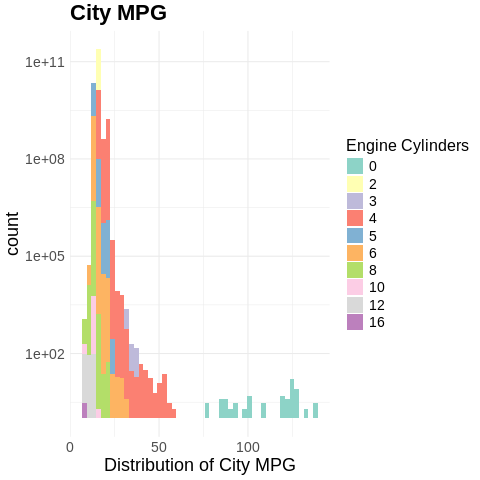

In [24]:
%%R
# unique color palette
cyl_levels <- sort(unique(df_car$`Engine Cylinders`))
cyl_colors <- setNames(brewer.pal(n = length(cyl_levels), name = "Set3"), cyl_levels)

# Histogram: distribution for the 'city mpg'
plot1 <- ggplot(df_car, aes(x = `city mpg`, fill = factor(`Engine Cylinders`, levels = cyl_levels))) +
  geom_histogram(bins = 50, position = "stack") +
  scale_y_log10() +
  scale_fill_manual(values = cyl_colors) +
  labs(title = "City MPG", x = "Distribution of City MPG", fill = "Engine Cylinders") +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 22, face = "bold"),
    axis.title = element_text(size = 18),
    axis.text = element_text(size = 14),
    legend.title = element_text(size = 16),
    legend.text = element_text(size = 14)
  )

# save as png-file
ggsave(filename = file.path(save_path, "city_mpg_large.png"), plot = plot1, width = 14, height = 8, dpi = 300)

# Grid layout
grid.arrange(plot1)


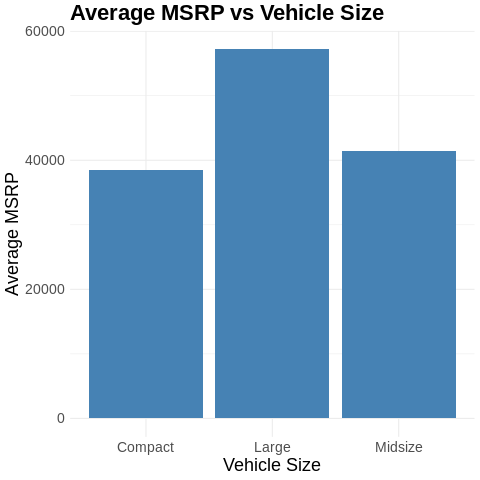

In [25]:
%%R

# Bar chart
avg_msrp <- df_car %>%
  group_by(`Vehicle Size`) %>%
  summarize(mean_msrp = mean(MSRP, na.rm = TRUE))

plot2 <- ggplot(avg_msrp, aes(x = `Vehicle Size`, y = mean_msrp)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  labs(
    title = "Average MSRP vs Vehicle Size",
    x = "Vehicle Size",
    y = "Average MSRP"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 22, face = "bold"),
    axis.title.x = element_text(size = 18),
    axis.title.y = element_text(size = 18),
    axis.text = element_text(size = 14),
    legend.title = element_text(size = 16),
    legend.text = element_text(size = 14)
  )

# save as png-file
ggsave(filename = file.path(save_path, "avg_msrp_vehicle_size.png"), plot = plot2, width = 14, height = 8, dpi = 300)

# Grid layout
grid.arrange(plot2)

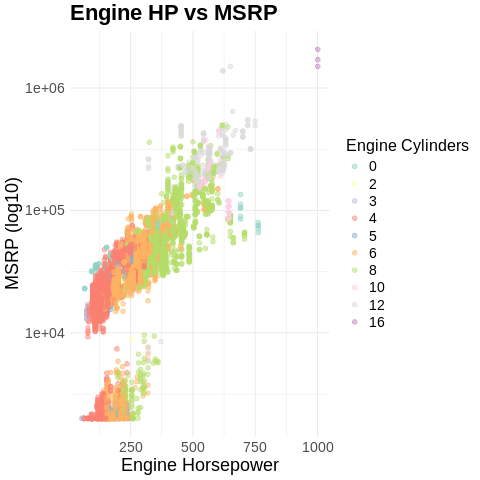

In [26]:
%%R
# Scatter plot
plot3 <- ggplot(df_car, aes(x = `Engine HP`, y = MSRP, color = factor(`Engine Cylinders`, levels = cyl_levels))) +
  geom_point(alpha = 0.5, size = 2) +
  scale_y_log10() +
  scale_color_manual(values = cyl_colors) +
  labs(title = "Engine HP vs MSRP", x = "Engine Horsepower", y = "MSRP (log10)", color = "Engine Cylinders") +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 22, face = "bold"),
    axis.title = element_text(size = 18),
    axis.text = element_text(size = 14),
    legend.title = element_text(size = 16),
    legend.text = element_text(size = 14)
  )

# save as png-file
ggsave(filename = file.path(save_path, "engine_hp_vs_msrp.png"), plot = plot3, width = 14, height = 8, dpi = 300)

# Grid layout
grid.arrange(plot3)


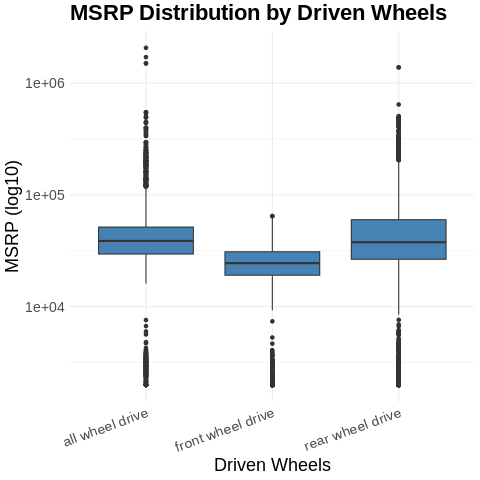

In [27]:
%%R

# Boxplot
plot4 <- ggplot(df_car, aes(x = `Driven_Wheels`, y = MSRP)) +
  geom_boxplot(fill = "steelblue") +
  scale_y_log10() +
  labs(
    title = "MSRP Distribution by Driven Wheels",
    x = "Driven Wheels",
    y = "MSRP (log10)"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 22, face = "bold"),
    axis.title.x = element_text(size = 18),
    axis.title.y = element_text(size = 18),
    axis.text = element_text(size = 14),
    axis.text.x = element_text(angle = 20, hjust = 1),
    legend.title = element_text(size = 16),
    legend.text = element_text(size = 14)
  )

# save as png-file
ggsave(filename = file.path(save_path, "msrp_by_driven_wheels.png"), plot = plot4, width = 14, height = 8, dpi = 300)

# Grid layout
grid.arrange(plot4)


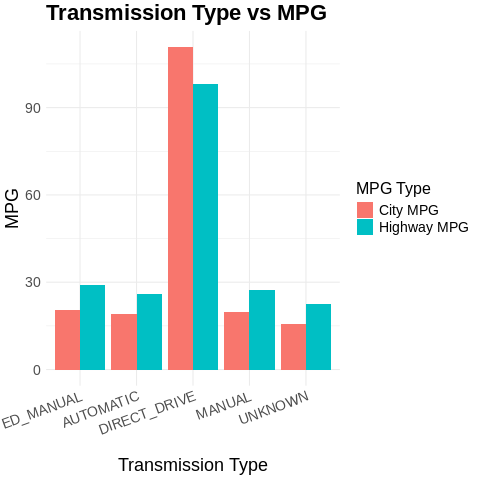

In [28]:
%%R

# Calculate average city and highway MPG by Transmission Type
transmission_vs_MPG <- df_car %>%
  group_by(`Transmission Type`) %>%
  summarize(
    `City MPG` = mean(`city mpg`, na.rm = TRUE),
    `Highway MPG` = mean(`highway MPG`, na.rm = TRUE)
  )

# Reshape to long format for grouped bar chart
mpg_long <- pivot_longer(
  transmission_vs_MPG,
  cols = c(`City MPG`, `Highway MPG`),
  names_to = "MPG Type",
  values_to = "MPG"
)

# Grouped bar chart: Transmission Type vs MPG
plot5 <- ggplot(mpg_long, aes(x = `Transmission Type`, y = MPG, fill = `MPG Type`)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(
    title = "Transmission Type vs MPG",
    y = "MPG",
    x = "Transmission Type",
    fill = "MPG Type"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 22, face = "bold"),
    axis.title.x = element_text(size = 18),
    axis.title.y = element_text(size = 18),
    axis.text = element_text(size = 14),
    axis.text.x = element_text(angle = 20, hjust = 1),
    legend.title = element_text(size = 16),
    legend.text = element_text(size = 14)
  )

# save as png-file
ggsave(filename = file.path(save_path, "transmission_vs_mpg.png"), plot = plot5, width = 14, height = 8, dpi = 300)

# Plot anzeigen
grid.arrange(plot5)


  ### 4.4 Correlation Analysis in R

Investigate the correlation between the following variables:
    - 'Engine HP'
    - 'MSRP'
    - 'Popularity'
    - 'city mpg'
    - 'highway MPG'

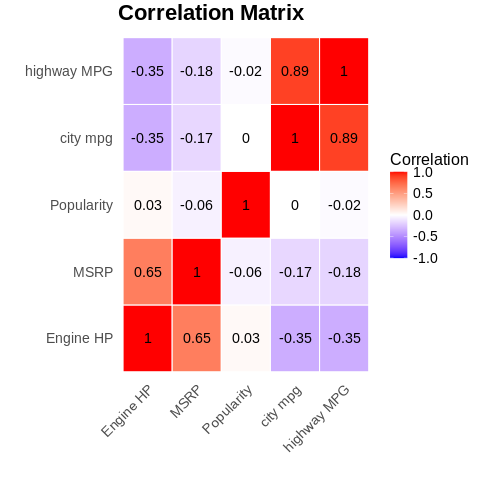

In [29]:
%%R

# extract only relevant numerical colums
corr_data <- df_car[, c("Engine HP", "MSRP", "Popularity", "city mpg", "highway MPG")]

# calculate correlation matrix
corr_matrix <- round(cor(corr_data, use = "complete.obs"), 2)

# convert Matrix into long format for ggplot2
melted_corr <- melt(corr_matrix)

# Heatmap with ggplot2
plot_corr <- ggplot(data = melted_corr, aes(x = Var1, y = Var2, fill = value)) +
  geom_tile(color = "white", linewidth = 0.5) +
  scale_fill_gradient2(
    low = "blue", high = "red", mid = "white",
    midpoint = 0, limit = c(-1, 1), space = "Lab",
    name = "Correlation"
  ) +
  geom_text(aes(label = round(value, 2)), color = "black", size = 5) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 22, face = "bold"),
    axis.title = element_text(size = 18),
    axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1, size = 14),
    axis.text.y = element_text(size = 14),
    legend.title = element_text(size = 16),
    legend.text = element_text(size = 14),
    panel.grid.major = element_blank()
  ) +
  labs(
    title = "Correlation Matrix",
    x = "",
    y = ""
  )

# save as png-file
ggsave(filename = file.path(save_path, "correlation_matrix.png"), plot = plot_corr, width = 12, height = 10, dpi = 300)

# Plot anzeigen
grid.arrange(plot_corr)





## 5. Share - Key Insights and Findings
***
**Data Preparation & Feature Engineering**

- Missing values were successfully addressed, either by manual research or strategic replacement.

- New columns (Total MPG, Price per HP) were created to support deeper analysis of fuel efficiency and performance.
***
**Visual Insights**

- **City MPG (Histogram):**
Most vehicles achieve around 15 MPG in the city. Cars with higher MPG tend to have fewer engine cylinders, indicating greater efficiency. Conversely, cars with larger engines (more cylinders) appear to be more popular despite lower efficiency.

- **Vehicle Size vs. Price (Bar Chart):**
Larger cars have the highest average MSRP ($58,000), followed by midsize ($42,000), and compact vehicles (~$38,000), suggesting a clear size-price relationship.

- **Performance vs. Price (Scatter Plot):**
There is a strong positive correlation between Engine HP and MSRP. Additionally, higher HP is associated with more engine cylinders, reflecting that more powerful engines are costlier and more complex.

- **Drive Type and Price Distribution (Box Plot):**
AWD and RWD vehicles have similar median MSRP ($35,000), although RWD has a wider price range. AWD includes several luxury outliers priced above $1M. FWD vehicles have a lower median MSRP ($25,000), with a tighter IQR.

- **Transmission Type and Fuel Efficiency (Line Plot):**
Cars with 'Direct Drive' transmissions show significantly higher MPG values. Other transmission types (manual, automatic, CVT) display similar average fuel efficiency ranges.

- **Correlation Analysis:**

  - **Positive:** MSRP strongly correlates with Engine HP.

  - **Negative:** MPG (city & highway) values inversely correlate with Engine HP.

  - **No Correlation:** Popularity shows no meaningful correlation with any numerical feature.

  - **High internal correlation:** City MPG and Highway MPG are strongly positively correlated.

##6. Act – Recommendations
***
I have created the following visualizationsBased on the findings from the exploratory analysis of the vehicle dataset, the following data-driven recommendations are proposed:

1. **Segment marketing by vehicle size and price sensitivity**
Compact and mid-size cars offer better fuel efficiency at lower MSRP levels. These segments should be promoted as cost-effective and environmentally conscious options that are particularly attractive to urban and price-conscious consumers.

2. **Positioning all-wheel drive vehicles with high performance as premium products**
Vehicles with all-wheel drive and high engine power have a significantly higher price and often belong to the luxury class. These models should be marketed to premium class buyers who value performance, safety or off-road capability.

3. **Emphasizing fuel efficiency in product development and campaigns**
Fuel efficiency (MPG) correlates strongly with vehicle type and transmission. Models with 'Direct Drive' transmissions are characterized by a high MPG value. Manufacturers and dealers should emphasize this advantage in marketing and consider expanding the product range in this segment.

4. **Devaluation of “popularity” as an independent key figure**
The data shows that popularity does not correlate meaningfully with MSRP, performance or efficiency. Future strategies should focus more on interieur features, which are meaningful for daily usage.